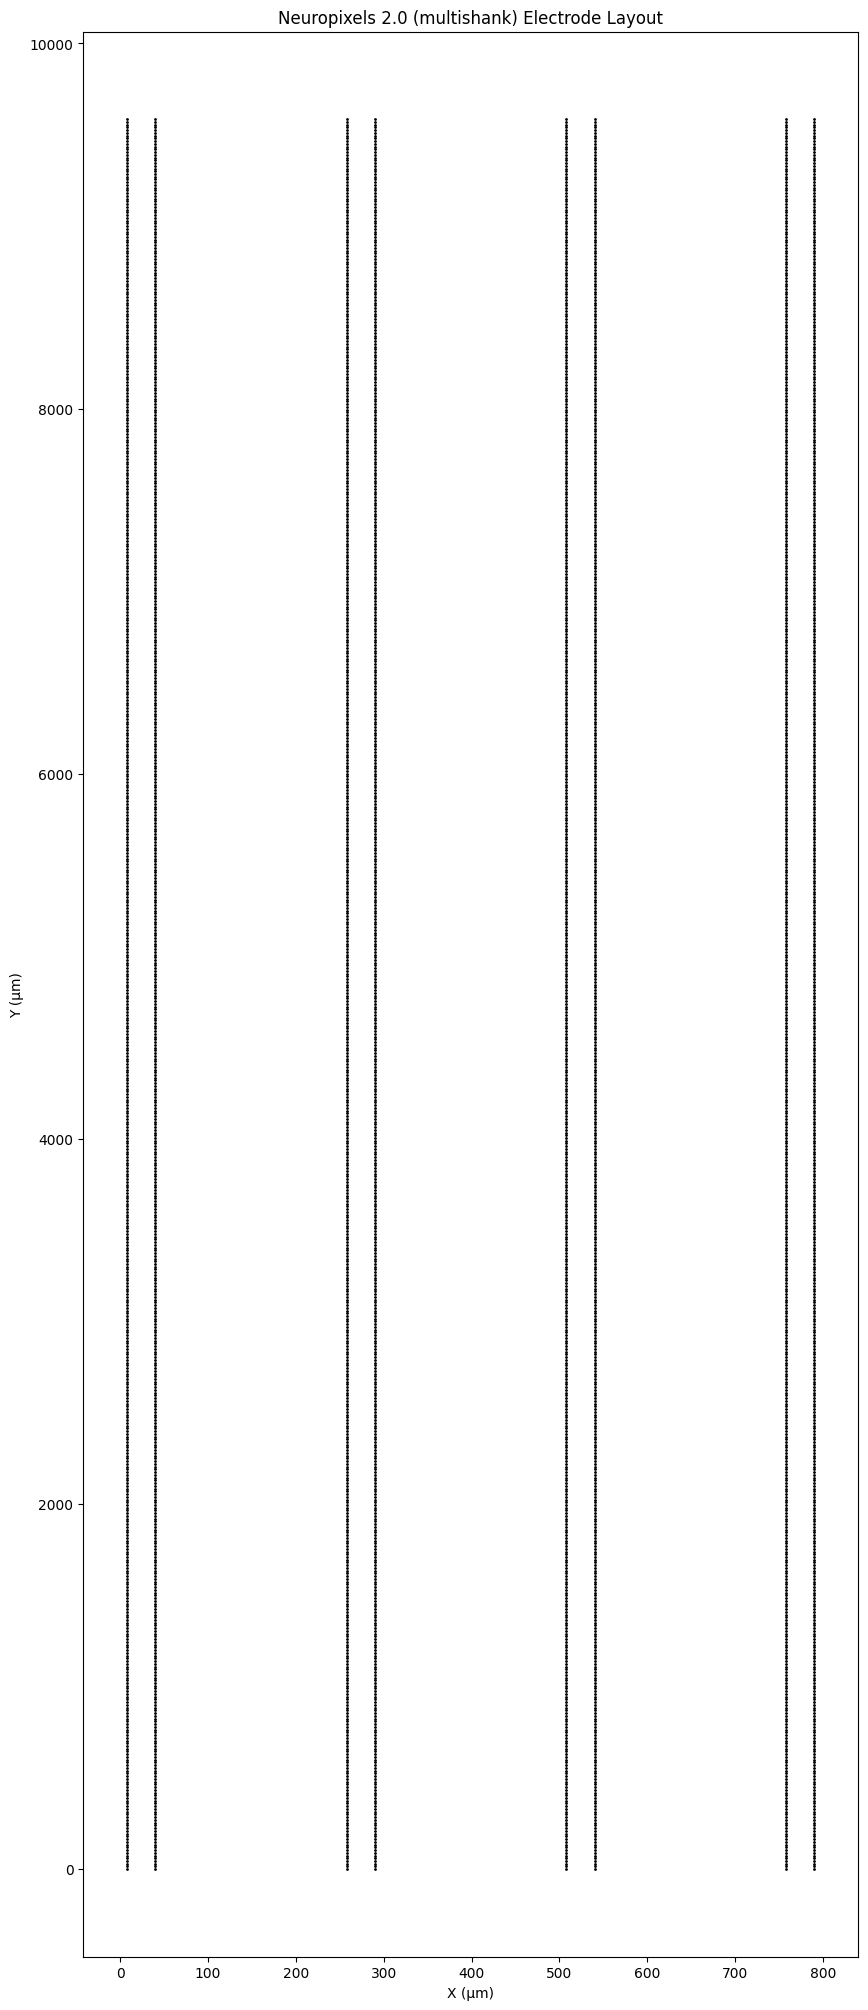

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

electrodes = []

# Specs for Neuropixels 2.0 multishank probe
num_shanks = 4
electrodes_per_shank = 1280
inter_shank_spacing = 250  # um between shanks
horizontal_spacing = 32    # um between columns
vertical_spacing = 15      # um between rows
x_offset = 8 # This is needed to match the settings xml files from Open Ephys. I wish I had a better explanation!

for shank in range(num_shanks):
    base_index = shank * electrodes_per_shank
    for site_in_shank in range(electrodes_per_shank):
        electrode = base_index + site_in_shank
        column = site_in_shank % 2  # 0 (left), 1 (right)
        row = site_in_shank // 2

        x = shank * inter_shank_spacing + column * horizontal_spacing + x_offset
        y = row * vertical_spacing

        electrodes.append({
            "electrode": electrode,
            "shank": shank,
            "shank_column": column,
            "shank_row": row,
            "x_um": x,
            "y_um": y
        })

# Save to a csv
df = pd.DataFrame(electrodes)
df.to_csv("neuropixels_2.0_multishank_electrode_coords.csv", index=False)

# Plot it
plt.figure(figsize=(10, 25))
plt.scatter(df['x_um'], df['y_um'], s=1, color='black')
plt.title("Neuropixels 2.0 (multishank) Electrode Layout")
plt.xlabel("X (µm)")
plt.ylabel("Y (µm)")
plt.xlim(df['x_um'].min() - 50, df['x_um'].max() + 50)
plt.savefig("neuropixels_2.0_multishank_all_electrodes.png", dpi=300, bbox_inches='tight')
plt.show()


In [62]:
import xml.etree.ElementTree as ET
%matplotlib qt

#settings_file_path = '/Volumes/Tim/Neuropixel2.0/openephys_data/sync_and_probe2025-05-08_00-07-51/Record Node 114/settings.xml'
settings_file_path = '/Volumes/Dan/2025/NeuroPixel/OpenEphys/shank1_saline_tip2025-06-06_14-42-51/Record Node 101/settings_2.xml'
all_probes_data = {}

# Load the settings.xml
tree = ET.parse(settings_file_path)
root = tree.getroot()

# Parse each PROBE
probes = root.findall(".//NP_PROBE")
for i, probe in enumerate(probes):
    # Make an id for each probe in case there are multiple (there will be 2 if we do bilateral recordings)
    probe_id = f"probe_{i}"

    # Get electrode config preset name
    electrode_config_name = probe.get("electrodeConfigurationPreset")
    print(f"NP_PROBE {i}: electrodeConfigurationPreset = '{electrode_config_name}'")

    # Initialize channel map for this probe
    channel_map = {}

    # Parse CHANNELS
    channels_element = probe.find("CHANNELS")
    if channels_element is not None:
        for channel_name, shank_info in channels_element.attrib.items():
            if channel_name.startswith("CH"):
                channel_num = int(channel_name[2:])
                bank_str, shank_str = shank_info.split(":")
                channel_map[channel_num] = {
                    "channel_name": channel_name, 
                    "shank": int(shank_str), 
                    "bank(?)": int(bank_str)
                }

    # Parse ELECTRODE_XPOS
    xpos_element = probe.find("ELECTRODE_XPOS")
    if xpos_element is not None:
        for channel_name, xpos in xpos_element.attrib.items():
            if channel_name.startswith("CH"):
                channel_num = int(channel_name[2:])
                channel_map[channel_num]["x_um"] = int(xpos)

    # Parse ELECTRODE_YPOS
    ypos_element = probe.find("ELECTRODE_YPOS")
    if ypos_element is not None:
        for channel_name, ypos in ypos_element.attrib.items():
            if channel_name.startswith("CH"):
                channel_num = int(channel_name[2:])
                channel_map[channel_num]["y_um"] = int(ypos)
                
    # Create and sort dataframe
    channel_df = pd.DataFrame.from_dict(channel_map, orient='index')
    channel_df['channel_num'] = channel_df.index.astype(int)
    channel_df = channel_df.sort_values(by='channel_num').reset_index(drop=True)

    # Save this probe
    all_probes_data[probe_id] = {
        "electrode_config_name": electrode_config_name,
        "channel_df": channel_df,
    }
    
# For now we only want to deal with a single probe
if len(all_probes_data) != 1:
    raise ValueError(f"Expected exactly one probe, but found {len(all_probes_data)}!")

# There must be only one probe
probe_id, probe_data = next(iter(all_probes_data.items()))
channel_df = probe_data["channel_df"]

print("Channels from settings xml:")
display(channel_df)

# Load full electrode + coordinates data
all_electrodes_df = pd.read_csv("neuropixels_2.0_multishank_electrode_coords.csv")
print("All electrodes df:")
display(all_electrodes_df)

print(f"Validating data for {probe_id} and merging with full electrode data...")

# Merge with info for all electrodes using x_um, y_um, and shank
merged_df = pd.merge(
    channel_df,
    all_electrodes_df,
    on=["x_um", "y_um", "shank"],
    how="left",  # ensure we detect any missing matches
    validate="one_to_one"
)

# Check for unmatched rows
if merged_df["electrode"].isnull().any():
    missing = merged_df[merged_df["electrode"].isnull()]
    raise ValueError(
        f"Missing electrode match for {len(missing)} channels in {probe_id}:\n"
        f"{missing[['channel_num', 'x_um', 'y_um', 'shank']]}"
    )
print(f"{probe_id}: all channels matched and merged successfully!")

print("Merged data:")
display(merged_df)

# Save to csv
save_name = "shank1_saline_tip2025-06-06_14-42-51_electrode_info"
merged_df.to_csv(f"{save_name}.csv", index=False)

# Plot!!
plt.figure(figsize=(10, 25))
plt.scatter(all_electrodes_df["x_um"], all_electrodes_df["y_um"], color="black", s=1, label="All electrodes")
plt.scatter(merged_df["x_um"], merged_df["y_um"], color="red", s=1, label="Recording electrodes")
plt.title("Neuropixels 2.0 (multishank) Electrode Layout")
plt.xlabel("X (µm)")
plt.ylabel("Y (µm)")
plt.xlim(df['x_um'].min() - 50, df['x_um'].max() + 50)
plt.savefig("neuropixels_2.0_multishank_all_electrodes.png", dpi=300, bbox_inches='tight')
plt.legend()
plt.set_aspect('equal')
plt.show()

NP_PROBE 0: electrodeConfigurationPreset = 'NONE'
Channels from settings xml:


,channel_name,shank,bank(?),x_um,y_um,channel_num
0,CH0,0,1,8,2880,0
1,CH1,0,0,40,0,1
2,CH2,0,3,8,8655,2
3,CH3,0,2,40,5775,3
4,CH4,0,1,8,2910,4
...,...,...,...,...,...,...
379,CH379,0,1,40,4995,379
380,CH380,0,0,8,2130,380
381,CH381,0,0,40,2130,381
382,CH382,0,2,8,7905,382


All electrodes df:


,electrode,shank,shank_column,shank_row,x_um,y_um
0,0,0,0,0,8,0
1,1,0,1,0,40,0
2,2,0,0,1,8,15
3,3,0,1,1,40,15
4,4,0,0,2,8,30
...,...,...,...,...,...,...
5115,5115,3,1,637,790,9555
5116,5116,3,0,638,758,9570
5117,5117,3,1,638,790,9570
5118,5118,3,0,639,758,9585


Validating data for probe_0 and merging with full electrode data...
probe_0: all channels matched and merged successfully!
Merged data:


,channel_name,shank,bank(?),x_um,y_um,channel_num,electrode,shank_column,shank_row
0,CH0,0,1,8,2880,0,384,0,192
1,CH1,0,0,40,0,1,1,1,0
2,CH2,0,3,8,8655,2,1154,0,577
3,CH3,0,2,40,5775,3,771,1,385
4,CH4,0,1,8,2910,4,388,0,194
...,...,...,...,...,...,...,...,...,...
379,CH379,0,1,40,4995,379,667,1,333
380,CH380,0,0,8,2130,380,284,0,142
381,CH381,0,0,40,2130,381,285,1,142
382,CH382,0,2,8,7905,382,1054,0,527


AttributeError: module 'matplotlib.pyplot' has no attribute 'set_aspect'

In [52]:
path ='/Volumes/Dan/2025/NeuroPixel/OpenEphys/shank1_saline_tip2025-06-06_14-42-51/Record Node 101/experiment2/recording1/continuous/OneBox-100.ProbeA/continuous.dat'


In [ ]:
import matplotlib.pyplot as plt
%matplotlib qt

# Plot electrode positions for each probe!
for probe_id, probe_data in all_probes_data.items():
    electrode_config_name = probe_data["electrode_config_name"]
    channel_map = probe_data["channel_map"]
    print(f"Plotting coordinates for '{electrode_config_name}'")
    
    x_coords = []
    y_coords = []
    labels = []

    for channel_num, info in channel_map.items():
        x_coords.append(info.get("xpos"))
        y_coords.append(info.get("ypos"))
        labels.append(f"{channel_num}")
    
    # Plot electrode coordinates
    plt.figure(figsize=(8, 6))
    plt.scatter(x_coords, y_coords, color='blue', s=2)

    # Add channel number next to each electrode
    for i, label in enumerate(labels):
        plt.annotate(label, (x_coords[i], y_coords[i]), textcoords="offset points", xytext=(2, 0), ha='left', fontsize=9)

    plt.title(f"Neuropixels 2.0 Electrode Positions '{electrode_config_name}'")
    plt.xlabel("X Position")
    plt.ylabel("Y Position")
    plt.grid(True)
    plt.show()


Plotting coordinates for 'All Shanks 1-96'
Plotting coordinates for 'Shank 2 Bank A'
Plotting coordinates for 'All Shanks 1-96'
Plotting coordinates for 'Shank 3 Bank A'
Plotting coordinates for 'All Shanks 1-96'
Plotting coordinates for 'Shank 4 Bank A'
Plotting coordinates for 'All Shanks 1-96'
Plotting coordinates for 'Shank 1 Bank C'
Plotting coordinates for 'All Shanks 1-96'
Plotting coordinates for 'Shank 2 Bank C'
Plotting coordinates for 'All Shanks 1-96'
Plotting coordinates for 'Shank 3 Bank C'
Plotting coordinates for 'All Shanks 1-96'
Plotting coordinates for 'Shank 4 Bank C'
Plotting coordinates for 'All Shanks 1-96'
Plotting coordinates for 'All Shanks 1-96'
Plotting coordinates for 'All Shanks 1-96'
Plotting coordinates for 'All Shanks 97-192'
Plotting coordinates for 'All Shanks 1-96'
Plotting coordinates for 'All Shanks 193-288'
Plotting coordinates for 'All Shanks 1-96'
Plotting coordinates for 'All Shanks 289-384'


/var/folders/qw/_sndq4457jd616hb6zx68mw80000gn/T/ipykernel_88344/303241753.py:20: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(8, 6))


Plotting coordinates for 'All Shanks 1-96'
Plotting coordinates for 'All Shanks 385-480'
